In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import os
from zipfile import ZipFile

# 設定 data_path
dir_data = './data/'

In [223]:
f_path = os.path.join(dir_data, 'titanic.zip')
print('Path of read in data: %s' % (f_path))

myzip=ZipFile(f_path)
for i in myzip.filelist:
    print(i.filename)

Path of read in data: ./data/titanic.zip
gender_submission.csv
test.csv
train.csv


In [224]:
f=myzip.open('train.csv')
train=pd.read_csv(f)
f.close()

f=myzip.open('test.csv')
test=pd.read_csv(f)
f.close()

myzip.close()

In [225]:
print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (891, 12)
Testing data shape:  (418, 11)


In [226]:
def columns_type(df_data):
    dtype_df = df_data.dtypes.reset_index()
    dtype_df.columns = ['Columns', 'Type']
    dtype_df_count = dtype_df.groupby(['Type'])['Columns'].count().reset_index()
    for t, n in zip(dtype_df_count.Type, dtype_df_count.Columns):
        print('類型 : ',t,'\n')
        print('  個數 : ',n,'\n')
        print('  ',list(dtype_df[dtype_df.Type==t].Columns),'\n')
        print('-----------------------------------------------\n')
columns_type(train)

類型 :  int64 

  個數 :  5 

   ['PassengerId', 'Survived', 'Pclass', 'SibSp', 'Parch'] 

-----------------------------------------------

類型 :  float64 

  個數 :  2 

   ['Age', 'Fare'] 

-----------------------------------------------

類型 :  object 

  個數 :  5 

   ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'] 

-----------------------------------------------



In [227]:
def object_check(df_data):    
    object_type = df_data.select_dtypes(include=["object"]).apply(pd.Series.nunique, axis = 0).reset_index() 
    object_type.columns = ["Column", "Unique Count"]
    display(object_type.head(10))
object_check(train)

,Column,Unique Count
0,Name,891
1,Sex,2
2,Ticket,681
3,Cabin,147
4,Embarked,3


In [228]:
# 檢查 DataFrame 空缺值的狀態
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(train)

,Missing Ratio
Cabin,77.104377
Age,19.865320
Embarked,0.224467


In [229]:
# 訓練資料需要 train_X, train_Y / 預測輸出需要 ids(識別每個預測值), test_X
# 在此先抽離出 train_Y 與 ids, 而先將 train_X, test_X 該有的資料合併成 df, 先作特徵工程
train_Y = train['Survived']
ids = test['PassengerId']
train_X = train.drop(['PassengerId', 'Survived'] , axis=1)
test = test.drop(['PassengerId'] , axis=1)
df = pd.concat([train_X,test], axis=0)
df.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [231]:
print(df.shape)

(1309, 10)


In [230]:
print(df.columns)
df.describe()

Index(['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Embarked'],
      dtype='object')


,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,80.000000,8.000000,9.000000,512.329200


In [232]:
df_etl = df.copy()
# 'Pclass' OK

# 'SibSp', 'Parch' OK
df_etl['Total_Family']=df_etl['SibSp'] + df_etl['Parch']
df_etl['Total_Family_cut3']=pd.cut(df_etl['Total_Family'],3,labels=[0,1,2])

# 'Age' 補中位數
df_etl['Age']=df_etl['Age'].fillna(df_etl['Age'].median())

# 'Fare'
df_etl['Fare_qcut10']=pd.qcut(df_etl['Fare'],10,labels=range(10))

# 'Name' 
import re
pattern = re.compile('\S*\.')
df_etl['Name_title'] = df_etl['Name'].apply(lambda x: pattern.findall(x)[0])

# 'Sex' OK

# 'Ticket'
Ticket_c=df_etl.groupby(['Ticket'])['Name'].count().reset_index(name='n')
df_etl['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket'])
df_etl['tkts']=df['Ticket'].isin(Ticket_c[Ticket_c.n>1]['Ticket']).astype('int')

# 'Cabin' 補NA
df_etl['Cabin']=df_etl['Cabin'].fillna('NA')

# 'Embarked' 補NA
df_etl['Embarked']=df_etl['Embarked'].fillna('NA')


# drop
df_etl=df_etl.drop(columns=['Total_Family'])
df_etl=df_etl.drop(columns=['Name'])
df_etl=df_etl.drop(columns=['Ticket'])

# GET DUMMIES
df_etl=pd.get_dummies(df_etl,drop_first = True)
df_etl.head(10)

,Pclass,Age,SibSp,Parch,Fare,tkts,Sex_male,Cabin_A11,Cabin_A14,Cabin_A16,...,Name_title_Major.,Name_title_Master.,Name_title_Miss.,Name_title_Mlle.,Name_title_Mme.,Name_title_Mr.,Name_title_Mrs.,Name_title_Ms.,Name_title_Rev.,Name_title_Sir.
0,3,22.0,1,0,7.2500,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,38.0,1,0,71.2833,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,3,26.0,0,0,7.9250,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,35.0,1,0,53.1000,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,3,35.0,0,0,8.0500,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5,3,28.0,0,0,8.4583,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,1,54.0,0,0,51.8625,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
7,3,2.0,3,1,21.0750,1,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8,3,27.0,0,2,11.1333,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,2,14.0,1,0,30.0708,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [233]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve, precision_score, recall_score ###計算roc和auc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [234]:
df_mms = MinMaxScaler().fit_transform(df_etl)

In [235]:
train_num = train_Y.shape[0]
train_X = df_mms[:train_num]

In [236]:
train_X.shape

(891, 224)

In [237]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_Y, test_size=0.3, random_state=42)

In [238]:
model01 = LogisticRegression()

In [239]:
model01.fit(X_train,y_train)

LogisticRegression()

In [240]:
#(model01.predict_proba(X_train,)[:,1]>=0.5).astype('int') # 進行預測
y_pred = model01.predict_proba(X_test,)[:,1]

In [241]:
y_pred

array([0.72248469, 0.08342011, 0.1109187 , 0.64325678, 0.74273122,
       0.81797981, 0.68792611, 0.08020309, 0.71979757, 0.92028165,
       0.39727794, 0.08414687, 0.25060483, 0.13639303, 0.1434355 ,
       0.85092949, 0.37097764, 0.68794398, 0.230892  , 0.38356077,
       0.10598479, 0.27372722, 0.60722102, 0.05423485, 0.08623634,
       0.18101855, 0.49734755, 0.15144821, 0.19263886, 0.59881549,
       0.11217939, 0.62602111, 0.26443292, 0.53814359, 0.11347195,
       0.14998346, 0.26783804, 0.68792611, 0.82908103, 0.10124814,
       0.16392542, 0.06844246, 0.10126289, 0.13680185, 0.82051923,
       0.01489483, 0.05483451, 0.0523058 , 0.08097292, 0.4394689 ,
       0.72263005, 0.92234777, 0.01054479, 0.92704266, 0.08997741,
       0.90060841, 0.08245029, 0.96892852, 0.68793422, 0.71415066,
       0.10865152, 0.73739667, 0.85562087, 0.28906235, 0.13680185,
       0.79282283, 0.1988494 , 0.10009172, 0.1376842 , 0.96216044,
       0.85420082, 0.83064101, 0.41922668, 0.92545677, 0.10621

In [183]:
#model01.predict(X_train,) # 進行預測

In [196]:
#auc = metrics.roc_auc_score(y_test, y_pred) # 使用 roc_auc_score 來評估。 **這邊特別注意 y_pred 必須要放機率值進去!**

1.0

In [242]:
fpr,tpr,threshold = roc_curve(y_test, y_pred) ###計算真正率和假正率
roc_auc = auc(fpr,tpr) ###計算auc的值

In [245]:
roc_auc

0.8874734607218684

<Figure size 432x288 with 0 Axes>

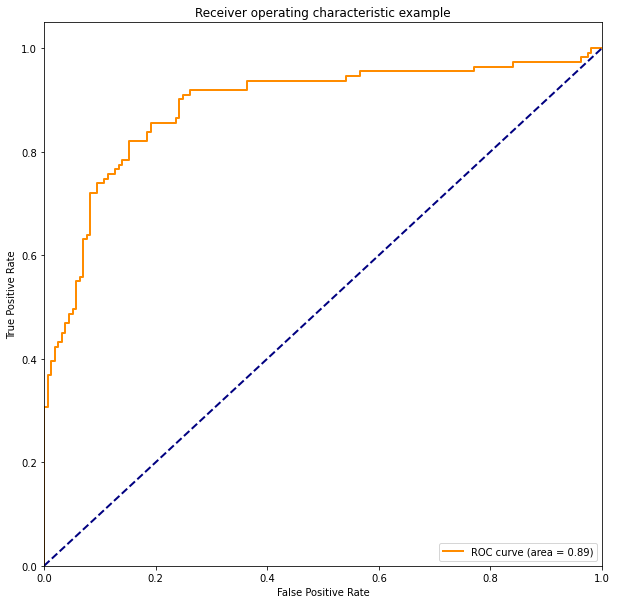

In [244]:
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) ###假正率為橫座標，真正率為縱座標做曲線
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

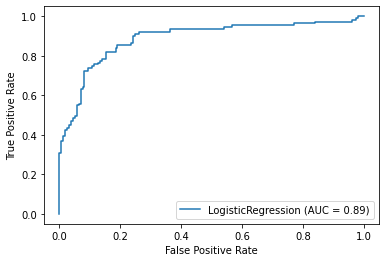

In [246]:
plot_roc_curve(model01, X_test, y_test)

In [248]:
threshold = 0.5 
y_pred_binarized = np.where(y_pred>threshold, 1, 0) # 使用 np.where 函數, 將 y_pred > 0.5 的值變為 1，小於 0.5 的為 0
f1 = metrics.f1_score(y_test, y_pred_binarized) # 使用 F1-Score 評估
precision = metrics.precision_score(y_test, y_pred_binarized) # 使用 Precision 評估
recall  = metrics.recall_score(y_test, y_pred_binarized) # 使用 recall 評估
print("F1-Score: ", f1) 
print("Precision: ", precision)
print("Recall: ", recall)

F1-Score:  0.7830188679245282
Precision:  0.8217821782178217
Recall:  0.7477477477477478


In [ ]:
y_test, y_pred_binarized

In [219]:
(y_test == y_pred_binarized).sum()

268

In [221]:
len(y_test)

268

In [ ]:
train_num = train_Y.shape[0]
train_X = df_mms[train_num:]

In [ ]:
model01.predict(X_train,)